In [33]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas  as pd
import numpy as np
from enum import Enum

In [34]:
class Datasets(Enum):
    PPI = 1
    KKI = 2
    CORA = 3
    TERR = 4
    
DATASET_USED = Datasets.TERR

def get_ppi_dataset(emb_file):
    """
    returns a dataframe with embeddings and labels
    """
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    lines = [line for line in open(LABELS_FILE).read().splitlines()]
    node_ids = [int(line.split()[0]) for line in lines]
    labels = [list(map(int, line.split()[1:])) for line in lines]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

def get_kki_dataset(emb_file):
    """
    returns a dataframe with embeddings and labels
    """
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    labels = [[int(line)] for line in open(LABELS_FILE).read().splitlines()]
    node_ids = [x for x in range(1, len(labels)+1)]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

# Used as well for terroristrel graph
def get_cora_dataset(emb_file):
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    input_df = pd.read_csv(LABELS_FILE, header=None, names=["node_id", "label"])
    input_df_grouped = input_df.groupby(by=['node_id'])['label'].apply(list).reset_index(name ='labels')
    result_df = pd.merge(emb_df, input_df_grouped, on='node_id', how='inner')
    
    return result_df

if DATASET_USED == Datasets.TERR:
    FILE_NAME = "TerroristRel"
    LABELS_FILE = "../graph/TerrorisRel/TerroristRel.node_labels"
    emb_file = "../emb/TerroristRel.emb"
    INPUT_FILE = "../graph/TerrorisRel/TerroristRel.edges"
    df = get_cora_dataset(emb_file)
if DATASET_USED == Datasets.CORA:
    FILE_NAME = "cora"
    LABELS_FILE = "../graph/cora/cora.node_labels"
    emb_file = "../emb/cora.emb"
    INPUT_FILE = "../graph/cora/cora.edges"
    df = get_cora_dataset(emb_file)
elif DATASET_USED == Datasets.PPI:
    FILE_NAME = "ppi"
    LABELS_FILE = "../graph/PPI/ppi_labels.txt"
    emb_file = "../emb/ppi.emb"
    INPUT_FILE = "../graph/PPI/ppi.edgelist"
    df = get_ppi_dataset(emb_file)
elif DATASET_USED == Datasets.KKI:
    FILE_NAME = "KKI"
    LABELS_FILE = "../graph/KKI/KKI.node_labels"
    emb_file = "../emb/kki.emb"
    INPUT_FILE = "../graph/KKI/KKI.edges"
    df = get_kki_dataset(emb_file)
    
df.head()

,node_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f120,f121,f122,f123,f124,f125,f126,f127,f128,labels
0,126,-0.233398,0.150677,-0.467689,-0.144637,-0.199214,-0.247189,-0.281126,-0.055526,-0.148457,...,0.292934,0.074813,-0.094239,0.441123,0.575557,-0.091120,-0.473621,-0.033900,-0.234112,[2]
1,120,-0.158898,0.081275,-0.605265,-0.230407,-0.110799,-0.215735,-0.241985,0.070773,-0.098156,...,0.167845,-0.041002,-0.119213,0.368439,0.481831,0.016912,-0.460111,-0.034474,-0.181252,[2]
2,125,-0.230896,0.227075,-0.722653,-0.340134,-0.191869,-0.104645,-0.159327,-0.073393,-0.067792,...,0.107002,-0.003419,-0.180541,0.165857,0.264213,-0.010101,-0.492845,0.033807,-0.277855,[2]
3,128,-0.202243,0.173104,-0.637553,0.045365,-0.382987,-0.192707,-0.392803,-0.054293,-0.139644,...,0.072128,-0.059515,-0.068001,0.285797,0.344174,0.136901,-0.470190,0.014860,-0.188295,[2]
4,129,-0.344308,0.178972,-0.539242,-0.074589,-0.339896,-0.181921,-0.150962,-0.057977,-0.224745,...,0.130746,-0.108217,-0.230323,0.237770,0.513008,0.167077,-0.460232,-0.096057,-0.216030,[2]


In [35]:
# Extend prediction function for the OVR logistic regression model
# This code is taken from https://github.com/Kombustor/submission-ecir2020-randomwalks/blob/submission/impl/model/classify.py#L11
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        """
        return the labels with the highest k probabilities prediction, where k is the number of labels Y_test have
        """
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)

In [36]:
def evaluate(df, test_sizes, num_iter=10):
    evaluations_micro = []
    evaluations_macro = []

    Y = df['labels']
    X = df.drop(columns=['labels', 'node_id'])

    # binarize data
    binarizer = MultiLabelBinarizer()
    binarizer.fit(Y)

    # Linear regression uses L2 regularization by default
    ovr_lr =  OneVsRestClassifier(lr(solver='liblinear'))
    clf = TopKRanker(ovr_lr)

    for test_size in test_sizes:
        micro_scores = []
        macro_scores = []
        for x in range(num_iter):

            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

            Y_train = binarizer.transform(Y_train)

            top_k_list = [len(l) for l in Y_test]
            Y_test = binarizer.transform(Y_test)

            # evaluation
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test, top_k_list=top_k_list)

            micro_scores.append(f1_score(Y_test, Y_pred, average='micro', zero_division=0))
            macro_scores.append(f1_score(Y_test, Y_pred, average='macro', zero_division=0))
        
        evaluations_micro.append(sum(micro_scores)/num_iter*100)
        evaluations_macro.append(sum(macro_scores)/num_iter*100)
        print(f"Perc: {test_size}")
    return evaluations_micro, evaluations_macro

def plot_scores(micro, macro, test_size):
    fig, ax = plt.subplots(figsize=(12, 6))

    micro.reverse()
    macro.reverse()
    
    plt.plot(test_size, micro, marker='o', label='Micro F$_1$')
    plt.plot(test_size, macro, marker='o', label='Macro F$_1$')
        
    plt.xlabel("Training perc")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.savefig(f"../images/classification/test_sizes_{FILE_NAME}.png", dpi=300)

Perc: 0.1
Perc: 0.2
Perc: 0.3
Perc: 0.4
Perc: 0.5
Perc: 0.6
Perc: 0.7
Perc: 0.8
Perc: 0.9


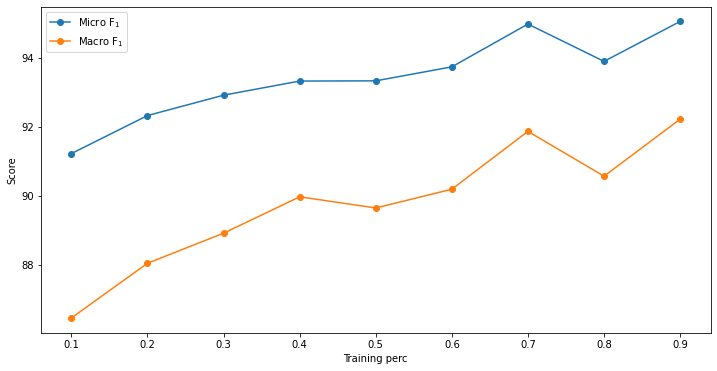

In [37]:
test_size_exp =  [x/10 for x in range(1, 10)]
micro, macro = evaluate(df, test_size_exp, 10)
plot_scores(micro, macro, test_size_exp)

# Grid search for q and p

In [7]:
import subprocess

def run_node2vec(input_file, output_file, p=1, q=1, is_weighted=False, delimiter='" "'):
    cmd = f"python main.py --p {p} --q {q} --input {input_file} --output {output_file} --delimiter {delimiter}"
    if is_weighted: cmd += " --weighted"
    subprocess.run(cmd, shell=True, stdout=subprocess.PIPE)

In [40]:
RUN_NODE2VEC_FOR_GRID_SEARCH = True

grid = {
    'q': [0.25, 0.50, 1, 2, 4],
    'p': [0.25, 0.50, 1, 2, 4]
}

evaluations = []

for p in grid['p']:
    for q in grid['q']:
        print(f"p: {p} q: {q}")
            
        emb_file =  f"../emb/{FILE_NAME}_q_{q}_p_{p}.emb"

        if RUN_NODE2VEC_FOR_GRID_SEARCH:
            if DATASET_USED == Datasets.PPI:
                run_node2vec(INPUT_FILE, emb_file, p, q, True)
            elif DATASET_USED == Datasets.CORA:
                run_node2vec(INPUT_FILE, emb_file, p, q, True, ",")
            elif DATASET_USED == Datasets.TERR:
                run_node2vec(INPUT_FILE, emb_file, p, q, False, ",")

        if DATASET_USED == Datasets.PPI:
            df = get_ppi_dataset(emb_file)
        if DATASET_USED == Datasets.TERR:
            df = get_cora_dataset(emb_file)
        elif DATASET_USED == Datasets.CORA:
            df = get_cora_dataset(emb_file)
            
        micro, macro = evaluate(df, [0.5])
        
        evaluations.append((q, p, micro, macro))

p: 0.25 q: 0.25


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1528.23it/s] 


Perc: 0.5
p: 0.25 q: 0.5


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1601.84it/s]


Perc: 0.5
p: 0.25 q: 1


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1510.06it/s] 


Perc: 0.5
p: 0.25 q: 2


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1635.68it/s]


Perc: 0.5
p: 0.25 q: 4


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1442.72it/s] 


Perc: 0.5
p: 0.5 q: 0.25


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1453.52it/s] 


Perc: 0.5
p: 0.5 q: 0.5


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1484.18it/s] 


Perc: 0.5
p: 0.5 q: 1


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1599.54it/s]


Perc: 0.5
p: 0.5 q: 2


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1550.75it/s]


Perc: 0.5
p: 0.5 q: 4


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1507.66it/s]


Perc: 0.5
p: 1 q: 0.25


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1554.93it/s] 


Perc: 0.5
p: 1 q: 0.5


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1536.72it/s] 


Perc: 0.5
p: 1 q: 1


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1582.67it/s] 


Perc: 0.5
p: 1 q: 2


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1494.97it/s]


Perc: 0.5
p: 1 q: 4


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1581.20it/s] 


Perc: 0.5
p: 2 q: 0.25


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1453.77it/s] 


Perc: 0.5
p: 2 q: 0.5


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1536.83it/s] 


Perc: 0.5
p: 2 q: 1


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1537.42it/s] 


Perc: 0.5
p: 2 q: 2


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1477.66it/s] 


Perc: 0.5
p: 2 q: 4


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1435.19it/s] 


Perc: 0.5
p: 4 q: 0.25


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:06<00:00, 1382.82it/s] 


Perc: 0.5
p: 4 q: 0.5


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:07<00:00, 1175.25it/s]


Perc: 0.5
p: 4 q: 1


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1499.44it/s]


Perc: 0.5
p: 4 q: 2


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:05<00:00, 1539.16it/s] 


Perc: 0.5
p: 4 q: 4


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 8592/8592 [00:06<00:00, 1363.53it/s] 


Perc: 0.5


In [41]:
# Max micro and macro scores
micro = [x[2][0] for x in evaluations]
macro = [x[3][0] for x in evaluations]

max_micro_index = micro.index(max(micro))
max_macro_index = macro.index(max(macro))

print(evaluations[max_micro_index])
print(evaluations[max_macro_index])

(1, 0.5, [95.01133786848072], [92.22399294394675])
(4, 0.5, [94.98866213151928], [92.23012521945651])


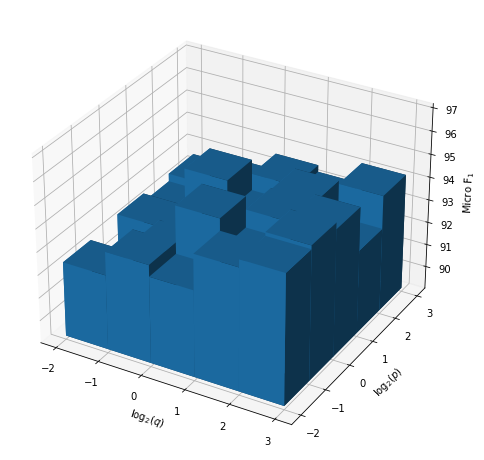

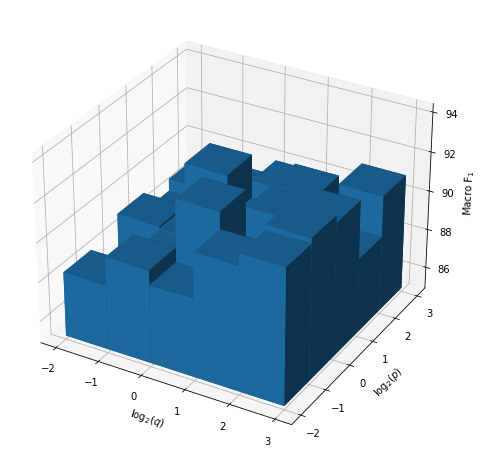

In [42]:
class Scores(Enum):
    MACRO = 1
    MICRO = 2
    
q = [np.log2(x[0]) for x in evaluations]
p = [np.log2(x[1]) for x in evaluations]
micro = [x[2][0] for x in evaluations]
macro = [x[3][0] for x in evaluations]

def plot_grid(p, q, scores, score_enum):
    q = np.array(q)
    p = np.array(p)
    scores = np.array(scores)
    
    if score_enum == Scores.MICRO:
        exp_name =  "micro_score"
        label = "Micro F$_1$"
    elif score_enum == Scores.MACRO:
        exp_name =  "macro_score"
        label = "Macro F$_1$"

    fig = plt.figure(figsize=(8, 16))
    ax = fig.add_subplot(111, projection='3d')

    
    min_lim = min(scores)-2
    max_lim = max(scores)+2
    ax.bar3d(q, p, min_lim*np.ones(len(scores)),
              1, 1, scores-min_lim)
    
    ax.set(zlim=(min_lim, max_lim))

    ax.set_xlabel('$\log_2(q)$')
    ax.set_ylabel('$\log_2(p)$')
    ax.set_zlabel(label)
    plt.savefig(f"../images/classification/grid_{exp_name}_{FILE_NAME}.png", dpi=500)

plot_grid(p, q, micro, Scores.MICRO)
plot_grid(p, q, macro, Scores.MACRO)

# Scalability (Not used in presentation)

In [12]:
import time
import networkx as nx


NODES_NUM_LIST = [500, 1000, 1500, 2000]
EDGE_PROB = 0.1
wall_time_experiments = []

def export_graph(G, relative_path):
    G_int = nx.convert_node_labels_to_integers(G, first_label = 0)
    nx.readwrite.edgelist.write_edgelist(G = G_int, path = relative_path, data = False)

for nodes_num in NODES_NUM_LIST:
    G = nx.generators.random_graphs.erdos_renyi_graph(nodes_num, EDGE_PROB)

    input_relative_path = f"../graph/scalability/nodesNum_{nodes_num}_scalability.edgelist"
    export_graph(G, input_relative_path)
    output_relative_path = f"../graph/scalability/nodesNum_{nodes_num}_scalability.emb"
    
    start_time = time.time()
    run_node2vec(input_relative_path, output_relative_path)
    total_time = time.time() - start_time
    
    wall_time_experiments.append(total_time)
    print(f"Wall time for {nodes_num} nodes: {total_time}")

Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 12506/12506 [00:06<00:00, 1925.28it/s]


Wall time for 500 nodes: 7.317482948303223


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s][A

100%|██████████| 49901/49901 [00:35<00:00, 1425.61it/s]


Wall time for 1000 nodes: 36.452149391174316


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s][A

100%|██████████| 111917/111917 [01:28<00:00, 1258.79it/s]


Wall time for 1500 nodes: 90.9280309677124


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s][A

100%|██████████| 200277/200277 [03:33<00:00, 937.92it/s] 


Wall time for 2000 nodes: 216.68711972236633


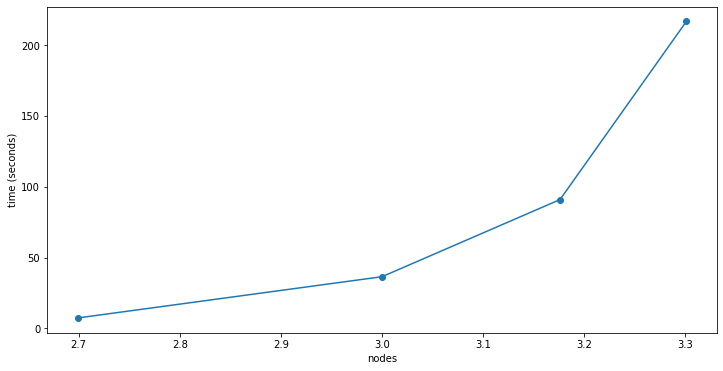

In [39]:
def plot_scalability_exp(nodes_num_list, wall_times):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    plt.plot(nodes_num_list, wall_times, marker='o')
        
    plt.xlabel("nodes")
    plt.ylabel("time (seconds)")
    plt.savefig(f"../images/classification/scalability.png", dpi=300)
aa = [np.log10(x) for x in NODES_NUM_LIST]
plot_scalability_exp(aa, wall_time_experiments)